In [1]:
import pandas as pd
import json

chipotle_ids = []

with open("yelp_academic_dataset_business.json", "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        name = obj.get("name", "").lower()
        if "chipotle" in name:
            chipotle_ids.append(obj["business_id"])

len(chipotle_ids)

157

In [2]:
chipotle_reviews = []

review_file = "yelp_academic_dataset_review.json"

with open(review_file, "r", encoding="utf-8") as f:
    for line in f:
        review = json.loads(line)
        if review["business_id"] in chipotle_ids:
            chipotle_reviews.append({
                "business_id": review["business_id"],
                "stars": review["stars"],
                "text": review["text"],
                "date": review["date"]
            })

len(chipotle_reviews)

9771

In [3]:
chipotle_df = pd.DataFrame(chipotle_reviews)
chipotle_df.to_csv("chipotle_reviews.csv", index=False)

In [4]:
import pandas as pd
df = pd.read_csv("chipotle_reviews.csv")
df["text"] = df["text"].fillna("")
df.head()

,business_id,stars,text,date
0,W7NxQw8UYFR0HLPrI08tvw,4.0,Don't know what it is but If my tummy's feelin...,2012-02-01 14:21:25
1,L7i_5DydYEKwPLfcDBRYDA,5.0,This Chipotle location was great! I wanted to ...,2017-05-13 14:09:53
2,C3Nc7EUqo64jRPWPn6vY9w,3.0,"Well I did visit here a Year ago, long before ...",2016-05-07 01:53:33
3,iAP8eZ847uCHLS-r81jUFg,5.0,I just recently moved to Idaho and today I wen...,2015-06-21 02:35:49
4,AmnnsJq4Pz1jJUFzHwtsOA,4.0,Can't believe I haven't tried Chipotle until t...,2013-06-24 07:38:03


In [5]:
positive = df[df["stars"] >= 4].copy()
negative = df[df["stars"] <= 2].copy()

len(positive), len(negative)


(3037, 5636)

## TF-IDF Bigram Analysis

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_tfidf_terms(texts, 
                        top_n=20, 
                        ngram_range=(1,2), 
                        min_df=5):
    vectorizer = TfidfVectorizer(
        stop_words="english",
        lowercase=True,
        ngram_range=ngram_range,
        min_df=min_df
    )
    
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Calculate the average TF-IDF score of each term across all documents
    mean_scores = tfidf_matrix.mean(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    
    scores_series = pd.Series(mean_scores, index=terms)
    # Sort in descending order and select the top n
    top_terms = scores_series.sort_values(ascending=False).head(top_n)
    
    return top_terms

In [7]:
top_pos_tfidf_bigram = get_top_tfidf_terms(
    texts=positive["text"],
    top_n=30,
    ngram_range=(2,2),   # bigram
    min_df=5
)
print(top_pos_tfidf_bigram)

fast food            0.019380
love chipotle        0.019264
burrito bowl         0.018492
customer service     0.016329
staff friendly       0.014197
food fresh           0.012785
food good            0.011622
food great           0.010667
sour cream           0.010359
good food            0.010122
great food           0.009658
black beans          0.009642
chipotle location    0.009581
best chipotle        0.009412
brown rice           0.008651
chicken burrito      0.008580
mexican food         0.008516
love place           0.007903
chipotle ve          0.007175
friendly staff       0.007088
parking lot          0.006700
great service        0.006397
burrito bowls        0.006213
food delicious       0.006120
service great        0.005632
like chipotle        0.005552
really good          0.005399
chipotle food        0.005390
fresh delicious      0.005336
white rice           0.005200
dtype: float64


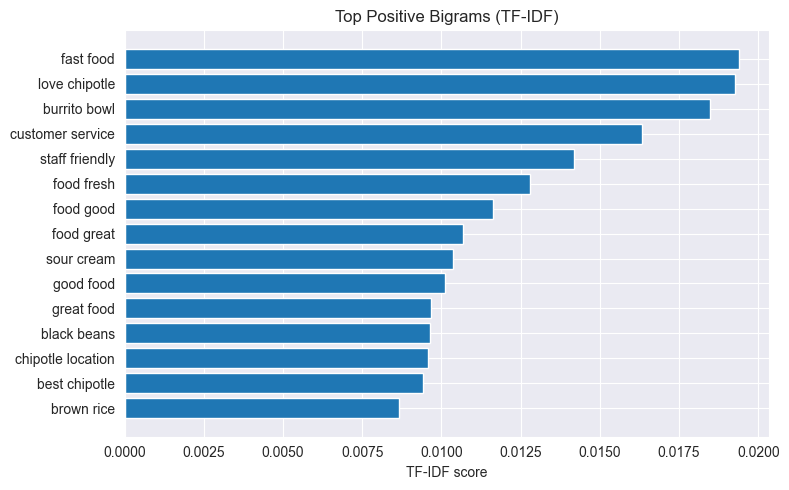

In [8]:
import matplotlib.pyplot as plt

pos_terms = top_pos_tfidf_bigram.head(15)

plt.figure(figsize=(8, 5))
plt.barh(pos_terms.index, pos_terms.values)
plt.gca().invert_yaxis()  
plt.xlabel("TF-IDF score")
plt.title("Top Positive Bigrams (TF-IDF)")
plt.tight_layout()

plt.savefig("chipotle_positive_bigrams_tfidf.png", dpi=300)
plt.show()

In [9]:
top_neg_tfidf_bigram = get_top_tfidf_terms(
    texts=negative["text"],
    top_n=30,
    ngram_range=(2,2),
    min_df=5
)
print(top_neg_tfidf_bigram)

customer service     0.015186
worst chipotle       0.013161
love chipotle        0.012469
sour cream           0.009164
burrito bowl         0.009005
chipotle location    0.008518
chipotle ve          0.008114
online order         0.007649
online orders        0.007197
don know             0.006279
order online         0.005547
20 minutes           0.005312
chips stale          0.005043
got home             0.004937
30 minutes           0.004936
ordered online       0.004839
brown rice           0.004736
food cold            0.004673
looked like          0.004569
10 minutes           0.004558
fast food            0.004403
white rice           0.004226
15 minutes           0.004127
food poisoning       0.004088
chicken bowl         0.004016
rice beans           0.003990
second time          0.003987
food good            0.003954
don care             0.003948
like chipotle        0.003866
dtype: float64


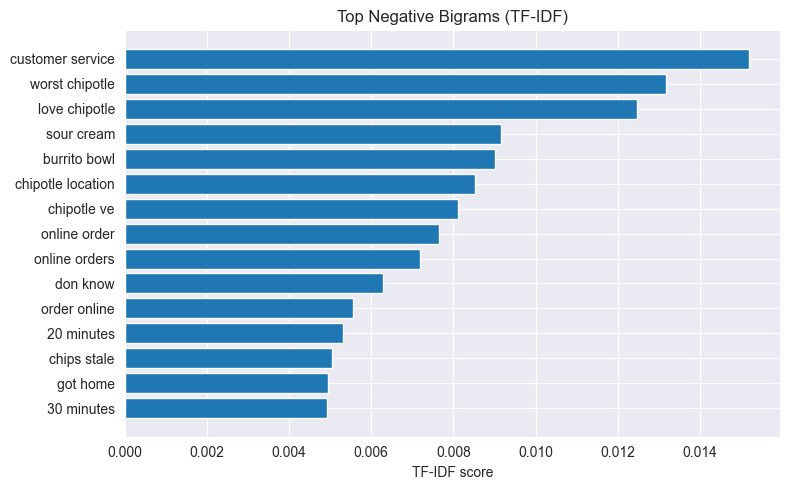

In [10]:
neg_terms = top_neg_tfidf_bigram.head(15)

plt.figure(figsize=(8, 5))
plt.barh(neg_terms.index, neg_terms.values)
plt.gca().invert_yaxis()
plt.xlabel("TF-IDF score")
plt.title("Top Negative Bigrams (TF-IDF)")
plt.tight_layout()

plt.savefig("chipotle_negative_bigrams_tfidf.png", dpi=300)
plt.show()

## Aspect-Based Sentiment Analysis using Emotion–Aspect Co-Occurrence

In [11]:
positive_emotions = ["good", "great", "love", "fresh", "friendly", "tasty", "best", "delicious"]
negative_emotions = ["bad", "cold", "rude", "slow", "stale", "worst", "missing", "long"]

topics = ["food", "service", "line", "order", "bowl", "burrito", "staff", "rice"]

def co_occurrence(df, emotion_words, topics):
    pairs = {}
    for e in emotion_words:
        for t in topics:
            pairs[f"{e} {t}"] = df["text"].str.contains(e) & df["text"].str.contains(t)
    result = {k: v.sum() for k,v in pairs.items()}
    return pd.Series(result).sort_values(ascending=False)

pos_pairs = co_occurrence(positive, positive_emotions, topics)
neg_pairs = co_occurrence(negative, negative_emotions, topics)

pos_pairs.head(15), neg_pairs.head(15)

(good food         516
 great food        427
 fresh food        427
 friendly food     367
 love food         360
 friendly staff    328
 good burrito      311
 fresh burrito     254
 love burrito      244
 good service      241
 good bowl         234
 great service     228
 good rice         223
 delicious food    221
 love bowl         215
 dtype: int64,
 long order      319
 worst order     319
 long line       307
 cold food       291
 bad food        284
 long food       279
 bad order       273
 worst food      271
 rude food       248
 rude order      242
 cold order      240
 worst line      207
 rude service    201
 bad service     197
 slow line       188
 dtype: int64)

In [12]:
from pyecharts.charts import Bar, Grid
from pyecharts import options as opts

# 1. Data preparation
pos_data = top_pos_tfidf_bigram.head(15).sort_values(ascending=True).round(4)
neg_data = top_neg_tfidf_bigram.head(15).sort_values(ascending=True).round(4)

# 2. Draw a frontal chart (Set to green)
bar_pos = (
    Bar()
    .add_xaxis(pos_data.index.tolist())
    .add_yaxis(
        "TF-IDF Score",
        pos_data.values.tolist(),
        category_gap="40%",
        # Use itemstyle_opts to set the color
        itemstyle_opts=opts.ItemStyleOpts(color="#91cc75")
    )
    .reversal_axis()
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Top Positive Key Phrases", pos_left="15%"),
        yaxis_opts=opts.AxisOpts(name="Phrase"),
        xaxis_opts=opts.AxisOpts(name="TF-IDF Score"),
        legend_opts=opts.LegendOpts(is_show=False)
    )
    .set_series_opts(
        label_opts=opts.LabelOpts(position="insideLeft")
    )
)

# 3. Draw a negative chart (Set to red)
bar_neg = (
    Bar()
    .add_xaxis(neg_data.index.tolist())
    .add_yaxis(
        "TF-IDF Score",
        neg_data.values.tolist(),
        category_gap="40%",
        # Use itemstyle_opts to set the color
        itemstyle_opts=opts.ItemStyleOpts(color="#ee6666")
    )
    .reversal_axis()
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Top Negative Key Phrases", pos_right="15%"),
        yaxis_opts=opts.AxisOpts(name="Phrase", position="right"),
        xaxis_opts=opts.AxisOpts(name="TF-IDF Score", is_inverse=True),
        legend_opts=opts.LegendOpts(is_show=False)
    )
    .set_series_opts(
        label_opts=opts.LabelOpts(position="insideRight")
    )
)

# 4. Grid Combine
grid = (
    Grid(init_opts=opts.InitOpts(width="100%", height="500px"))
    .add(bar_pos, grid_opts=opts.GridOpts(pos_right="55%"))
    .add(bar_neg, grid_opts=opts.GridOpts(pos_left="55%"))
)

grid.render_notebook()